In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import itertools
import os
import os.path
from Bio import motifs
from Bio import SeqIO
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
%matplotlib inline

In [2]:
# get ENCODE TF binding sites
tfbs = pd.read_table('c:/ravip/encode/wgEncodeRegTfbsClusteredV3.bed.gz',
                     header=None,names=['seqname','start','end','gene','score', 'nexpt', 'expts', 'expscores'],
                     dtype={'start':np.int, 'end':np.int})
tfbs[:5]

,seqname,start,end,gene,score,nexpt,expts,expscores
0,chr1,10073,10329,ZBTB33,354,2,"204,246","354,138"
1,chr1,10149,10413,CEBPB,201,1,343,201
2,chr1,16110,16390,CTCF,227,7,"213,612,621,627,628,631,662","110,139,171,209,227,200,170"
3,chr1,29198,29688,TAF1,184,1,157,184
4,chr1,29275,29591,GABPA,198,1,180,198


In [3]:
# expand tfbs by experiment
def splitrow(row, c1, c2, sep):
    rows = []
    for s1, s2 in zip(row[c1].split(sep), row[c2].split(sep)):
        row2 = row.to_dict()
        row2[c1] = s1
        row2[c2] = s2
        rows.append(row2)
    return rows
x = tfbs
x = pd.DataFrame(list(itertools.chain(*x.apply(lambda r: splitrow(r, 'expts', 'expscores', ','), axis=1))))
x = x.rename(columns={'expts': 'expt', 'expscores': 'expscore'})
tfbsx = x
tfbsx.expt = tfbsx.expt.astype(np.int64)
tfbsx[:5]

,end,expscore,expt,gene,nexpt,score,seqname,start
0,10329,354,204,ZBTB33,2,354,chr1,10073
1,10329,138,246,ZBTB33,2,354,chr1,10073
2,10413,201,343,CEBPB,1,201,chr1,10149
3,16390,110,213,CTCF,7,227,chr1,16110
4,16390,139,612,CTCF,7,227,chr1,16110


In [4]:
# read multi-stage mapping from experiment->cell->tissue->tissue type->cancer
tfmeta = pd.read_csv('c:/ravip/encode/wgEncodeRegTfbsClusteredInputsV3.tab.gz', sep='\t', names=['id','info','tf','antibody','cell','unk','site'])
tfmeta = tfmeta.reset_index().rename(columns={'index':'expt'})
celltypes = pd.read_csv('EncodeCellTypes.csv')
# for editing ... celltypes.Tissue.drop_duplicates().to_csv('EncodeTissues.csv',index=False,header=False)
celltissue = pd.read_csv('EncodeTissues.csv')
tcgatypes = pd.melt(pd.read_csv('TcgaTissues.csv'), id_vars=('TissueType'), var_name='cancer')
tcgatypes = tcgatypes[tcgatypes.value == 1][['TissueType','cancer']]

In [5]:
# join them all!
x = tfbsx.merge(tfmeta[['expt','cell']], how='left', on='expt')
x = x.rename(columns={'cell':'Cell'}).merge(celltypes[['Cell','Tissue']], how='left', on='Cell')
x = x.merge(celltissue, how='left', on='Tissue')
x = x.merge(tcgatypes, how='left', on='TissueType')
x = {g: tfs[['seqname','start','end','gene']].drop_duplicates() for g, tfs in x.groupby('cancer')}
tfbs_bycancer = x
print len(tfbs.start), {c: len(df.start) for c, df in tfbs_bycancer.iteritems()}

4380444 {'ACC': 579539, 'DLBC': 2630189, 'READ': 629785, 'GBM': 842568, 'LGG': 698906, 'THCA': 579539, 'STAD': 635962, 'UCEC': 1122254, 'PCPG': 842568, 'CESC': 1122254, 'UCS': 1122254, 'TGCT': 582053, 'LIHC': 1348731, 'CHOL': 1348731, 'HNSC': 894808, 'UVM': 584591, 'SKCM': 894275, 'COAD': 629785, 'PAAD': 600822, 'THYM': 579539, 'LUSC': 698906, 'MESO': 698906, 'OV': 579539, 'ESCA': 588733, 'SARC': 591423, 'KIRP': 638212, 'BLCA': 579539, 'LAML': 2630189, 'PRAD': 579539, 'LUAD': 698906, 'BRCA': 1028778, 'KIRC': 638212, 'KICH': 638212}


In [6]:
dna = pd.read_table('d:/sequence/pancan/tcga505/mutations.tsv.gz', dtype={'chr': np.character})
dna_rnd = pd.read_table('d:/sequence/pancan/tcga505/randomised_TCGA505_toshare.txt.gz',
                        header=None,names=['barcode', 'cancer', 'chr', 'pos', 'ref_allele', 'var_allele'],
                        dtype={'chr': np.character}, skiprows=1)
dna['rnd'] = False
dna_rnd['rnd'] = True
dna_all = dna.append(dna_rnd)
dna_all['chr'] = ['chr' + x for x in dna_all['chr']]

In [7]:
# get a set of TF binding matrices
with open('pfm_vertebrates.txt', 'r') as h:
    jaspar = {m.name.strip().split(':')[0].upper(): m.counts.normalize().log_odds() for m in motifs.parse(h, 'jaspar')}
list(jaspar.iteritems())[:2]

[('HSF1',
  {'A': [-1.1699250014423124,
    -2.813781191217037,
    -4.228818690495881,
    -5.813781191217037,
    -3.8137811912170374,
    1.186218808782963,
    -inf,
    1.7331132686705997,
    1.7253776198909943,
    -0.3543495725797397,
    -0.5283789723547887,
    -2.113341473075945,
    -2.813781191217037,
    -inf,
    -3.228818690495881],
   'C': [0.5437708134010467,
    -1.113341473075945,
    -2.3543495725797396,
    1.980634675133069,
    0.33596592828764493,
    -3.0064262691594332,
    -inf,
    -1.2288186904958809,
    -3.228818690495881,
    0.16349873228287956,
    0.14041511916983815,
    -1.813781191217037,
    -3.491853096329675,
    1.9544031335598895,
    0.6456504274202604],
   'G': [-0.006426269159432993,
    -2.228818690495881,
    -2.813781191217037,
    -4.813781191217037,
    -3.228818690495881,
    0.6619522397493607,
    2.0,
    -4.228818690495881,
    -1.9068905956085187,
    0.37604336766298013,
    0.25230799924073527,
    -2.643856189774725,
    -3.8

In [8]:
# reduce tfbs to those for which we have matrices
print len(set(tfbs['gene'])), len(set(jaspar.keys())), len(set(tfbs['gene']).intersection(set(jaspar.keys())))
common = set(tfbs['gene']).intersection(set(jaspar.keys()))
tfbs2 = tfbs[tfbs.gene.isin(common)]
tfbs_bycancer2 = {c: tf[tf.gene.isin(common)] for c,tf in tfbs_bycancer.iteritems()}
tfbs_bycancer2['CRC'] = tfbs_bycancer2['COAD']
print len(tfbs2.start), {c: len(tf.start) for c, tf in tfbs_bycancer2.iteritems()}

161 196 80
2820812 {'ACC': 312580, 'DLBC': 1528987, 'READ': 350545, 'GBM': 456438, 'THCA': 312580, 'STAD': 356722, 'UCEC': 664328, 'PCPG': 456438, 'CESC': 664328, 'UCS': 664328, 'THYM': 312580, 'LIHC': 867154, 'CHOL': 867154, 'HNSC': 568983, 'UVM': 317632, 'SKCM': 568450, 'COAD': 350545, 'BLCA': 312580, 'LUAD': 417628, 'TGCT': 313279, 'LUSC': 417628, 'MESO': 417628, 'KIRC': 352539, 'ESCA': 321774, 'CRC': 350545, 'SARC': 323199, 'KIRP': 352539, 'LGG': 417628, 'LAML': 1528987, 'PRAD': 312580, 'PAAD': 325658, 'BRCA': 722278, 'OV': 312580, 'KICH': 352539}


In [9]:
# get reference genome
hg19 = {contig.name: Seq(str(contig.seq), IUPAC.unambiguous_dna)
        for contig in SeqIO.parse('d:/sequence/genomes/hg19.fa', 'fasta')}

In [10]:
# left join by genomic regions
# limitations:
# genomic range columns (rcols1, rcols2) must be distinct
# only works if region sets are non-overlapping
# drops duplicates
def merge_regions(df1, cols1, df2, cols2):
    result = None
    [seqname1, start1, end1] = cols1[:3]
    [seqname2, start2, end2] = cols2[:3]
    cols1 = list(pd.Series(cols1).drop_duplicates())
    cols2 = list(pd.Series(cols2).drop_duplicates())
    for contig in set(df1[seqname1]).intersection(set(df2[seqname2])):
        c1 = df1[df1[seqname1]==contig].sort(end1).reset_index(drop=True)
        c2 = df2[df2[seqname2]==contig].sort(start2).drop_duplicates(start2).reset_index(drop=True)
        imerge = pd.cut(c1[end1], c2[start2], labels=False)
        keep = imerge >= 0
        cmerge = pd.concat([c1[cols1][keep], c2[cols2].iloc[imerge[keep]].reset_index(drop=True)], axis=1).reset_index(drop=True)
        cmerge = cmerge[cmerge[start1] <= cmerge[end2]]
        result = cmerge if result is None else pd.concat([result, cmerge])
    return result

In [8]:
# find TF binding regions matching mutations
mut_tf = merge_regions(dna_all, ['chr', 'pos', 'pos', 'ref_allele', 'var_allele', 'cancer', 'barcode', 'rnd'],
                       tfbs2, ['seqname', 'start', 'end', 'gene'])

In [11]:
# find TF binding regions matching mutations - using only TFs in tissues for cancer type
mut_tf = pd.concat([merge_regions(dna_c, ['chr', 'pos', 'pos', 'ref_allele', 'var_allele', 'cancer', 'barcode', 'rnd'],
                       tfbs_bycancer2[c], ['seqname', 'start', 'end', 'gene']) for c, dna_c in dna_all.groupby('cancer')])

In [12]:
# score TF binding to mutation using TF matrix
def score_mut(m):
    mx = jaspar[m['gene']]
    n = len(mx[mx.keys()[0]])
    p = int(m['pos'])
    refseq = hg19[m['chr']][p-n-1:p+n]
    refscore = reduce(max, (score for pos, score in mx.search(refseq, threshold=0.5) if score > 0 and pos >=0 and pos < n), 0)
    mutseq = refseq[:n] + m['var_allele'] + refseq[n+1:]
    mutscore = reduce(max, (score for pos, score in mx.search(mutseq, threshold=0.5) if score > 0 and pos >=0 and pos < n), 0)
    return (mutscore - refscore) / mx.max

In [13]:
from ipyparallel import Client
c = Client()
dview = c[:]

In [14]:
# push small global dataset, processing function
dview.push(dict(jaspar=jaspar, score_mut=score_mut))
# push hg19 doesn't work (reboots machine!), so read it in from each node
%px from Bio import motifs
%px from Bio import SeqIO
%px from Bio.Alphabet import IUPAC
%px from Bio.Seq import Seq
%px hg19 = {contig.name: Seq(str(contig.seq), IUPAC.unambiguous_dna) for contig in SeqIO.parse('d:/sequence/genomes/hg19.fa', 'fasta')}
# partition input DataFrame across nodes
dview.scatter('mut_tf', mut_tf)

<AsyncResult: scatter>

In [15]:
# run in parallel across all nodes ~4h on 20 cores
%px mut_tf_delta = mut_tf.apply(score_mut, axis=1)
mut_tf['delta'] = [x for x in itertools.chain(*dview.gather('mut_tf_delta').get())]

In [16]:
print mut_tf.describe()
mut_tf[:10]

                pos         start           end            delta
count  1.196546e+07  1.196546e+07  1.196546e+07  11965459.000000
mean   6.957436e+07  6.970448e+07  6.970480e+07        -0.001029
std    4.548008e+07  4.545848e+07  4.545848e+07         0.040589
min    5.127000e+03  9.992000e+03  1.025600e+04        -1.000000
25%    3.274165e+07  3.293552e+07  3.293582e+07         0.000000
50%    6.171015e+07  6.191359e+07  6.191386e+07         0.000000
75%    9.952669e+07  9.975343e+07  9.975380e+07         0.000000
max    2.492384e+08  2.492384e+08  2.492386e+08         1.000000


,chr,pos,ref_allele,var_allele,cancer,barcode,rnd,seqname,start,end,gene,delta
1,chrY,2687645,G,C,BLCA,TCGA-FD-A3N5-01A,True,chrY,2725678,2726059,CTCF,0
4,chrY,2769815,C,G,BLCA,TCGA-DK-A1A6-01A,False,chrY,2781143,2781555,CTCF,0
7,chrY,2799431,C,G,BLCA,TCGA-DK-A1A6-01A,True,chrY,2803947,2804329,CTCF,0
11,chrY,2836696,C,T,BLCA,TCGA-DK-A1AG-01A,True,chrY,2875610,2875918,CTCF,0
14,chrY,2922516,A,T,BLCA,TCGA-DK-A1AG-01A,True,chrY,2928718,2929088,CTCF,0
47,chrY,3271014,T,A,BLCA,TCGA-BT-A20T-01A,True,chrY,3273618,3274012,CTCF,0
53,chrY,3390275,T,G,BLCA,TCGA-BL-A13J-01A,False,chrY,3395031,3395420,CTCF,0
75,chrY,3773956,A,T,BLCA,TCGA-DK-A1AA-01A,False,chrY,3825324,3825694,CTCF,0
107,chrY,4270312,G,C,BLCA,TCGA-DK-A1A6-01A,True,chrY,4271932,4272202,CTCF,0
122,chrY,4446620,T,C,BLCA,TCGA-BT-A3PJ-01A,True,chrY,4460982,4461252,CTCF,0


KeyError: 0L

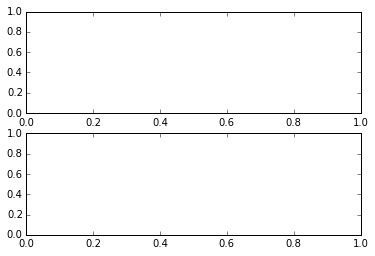

In [17]:
# compare rnd vs donor
fig, axes = plt.subplots(nrows=2)
ax0, ax1 = axes.flat
hdata = mut_tf[mut_tf.delta != 0].reset_index(drop=True)
ax0.hist(hdata.delta[hdata.rnd == True].sample(n=100000), bins=100, normed=True)
ax1.hist(hdata.delta[hdata.rnd == False].sample(n=100000).reset_index(drop=True), bins=100, normed=True)
plt.tight_layout()
plt.show()

In [42]:
# get DHS-gene (enhancer-promoter) table from Sheffield et al
dhsgene = pd.read_table('c:/ravip/encode/allGeneCorrelations100000.p05.txt.gz')

# join mutation TF region (enhancer) with promoter & target gene
mut_tf_prom_dhs = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'cancer', 'barcode', 'delta', 'rnd'],
                           dhsgene, ['dhs_chr', 'dhs_start', 'dhs_end', 'gene_name', 'cor'])

In [144]:
# get enhancer-gene assoiation from He et al
def read_he(f):
    df = pd.read_csv(os.path.join('data/he', f), header=1)
    df['CellLine'] = f[:-4]
    return df
hegene = pd.concat((read_he(f) for f in os.listdir('data/he') if f.endswith('.csv'))).rename(columns={'ID': 'gene_name'})
mut_tf_prom_he = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'cancer', 'barcode', 'delta', 'rnd'],
                           hegene, ['Chr', 'Start', 'End', 'gene_name'])
mut_tf_prom_he[:10]

In [18]:
# get enhancer-gene association from Ernst et al
def read_ernst(f):
    df = pd.read_csv(os.path.join('data/ernst', f), names=['enhchr','enhstart','enhend','gene_name'], sep='\t')
    df['CellLine'] = f.split('_')[1]
    return df
ernstgene = pd.concat((read_ernst(f) for f in os.listdir('data/ernst') if f.startswith('links_') & f.endswith('.txt')))
mut_tf_prom_ernst = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'cancer', 'barcode', 'delta', 'rnd'],
                           ernstgene, ['enhchr','enhstart','enhend', 'gene_name'])
mut_tf_prom_ernst[:10]

,seqname,start,end,gene,cancer,barcode,delta,rnd,enhchr,enhstart,enhend,gene_name
237,chrX,219573,219863,CEBPB,UCEC,TCGA-AX-A05S-01A,0,False,chrX,279400,279600,NM_013239
238,chrX,219573,219863,CEBPB,UCEC,TCGA-AP-A054-01A,0,True,chrX,279400,279600,NM_013239
239,chrX,219573,219863,CEBPB,LUAD,TCGA-05-4398-01A,0,True,chrX,279400,279600,NM_013239
240,chrX,219573,219863,CEBPB,LUAD,TCGA-55-6972-01A,0,True,chrX,279400,279600,NM_013239
241,chrX,219573,219863,CEBPB,UCEC,TCGA-AX-A0J1-01A,0,False,chrX,279400,279600,NM_013239
371,chrX,292601,292801,CTCF,SKCM,TCGA-DA-A3F8-06A,0,True,chrX,293000,293200,NM_013239
372,chrX,292601,292801,CTCF,SKCM,TCGA-DA-A1IC-06A,0,True,chrX,293000,293200,NM_013239
373,chrX,292601,292801,CTCF,HNSC,TCGA-CR-6467-01A,0,True,chrX,293000,293200,NM_013239
374,chrX,292601,292801,CTCF,SKCM,TCGA-DA-A1HW-06A,0,False,chrX,293000,293200,NM_013239
375,chrX,292601,292801,CTCF,SKCM,TCGA-D3-A3MO-06A,0,True,chrX,293000,293200,NM_013239


In [172]:
thurmangene = pd.read_table('data/thurman/genomewideCorrs_above0.7_promoterPlusMinus500kb_withGeneNames_32celltypeCategories.bed8.gz',
                            sep='\t', names=['promchr', 'promstart', 'promend', 'gene_name', 'enhchr', 'enhstart', 'enhend', 'cor'])
thurmangene = thurmangene.sort(['enhchr', 'enhstart', 'cor'], ascending=[1, 1, 0]).drop_duplicates(['enhchr', 'enhstart'])
mut_tf_prom_thurman = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'cancer', 'barcode', 'delta', 'rnd'],
                           thurmangene, ['enhchr','enhstart','enhend', 'gene_name'])
mut_tf_prom_thurman[:10]

,seqname,start,end,gene,cancer,barcode,delta,rnd,enhchr,enhstart,enhend,gene_name
0,chrY,2655169,2655545,YY1,SKCM,TCGA-DA-A1HY-06A,0,False,chrY,2655080,2655230,ASMTL
4,chrY,2668277,2668694,CTCF,CRC,TCGA-AA-A01R-01A,0,True,chrY,2668440,2668590,RPS4Y1
5,chrY,2668277,2668694,CTCF,LUSC,TCGA-37-4135-01A,0,True,chrY,2668440,2668590,RPS4Y1
6,chrY,2668277,2668694,CTCF,LUSC,TCGA-52-7812-01A,0,True,chrY,2668440,2668590,RPS4Y1
7,chrY,2668277,2668694,CTCF,SKCM,TCGA-ER-A19J-06A,0,True,chrY,2668440,2668590,RPS4Y1
8,chrY,2668277,2668694,CTCF,CRC,TCGA-CA-6717-01A,0,False,chrY,2668440,2668590,RPS4Y1
21,chrY,2706072,2706296,CEBPB,CRC,TCGA-CA-6718-01A,0,True,chrY,2706060,2706210,ASMTL
33,chrY,2755960,2756270,CTCF,KICH,TCGA-KO-8416-01A,0,False,chrY,2756120,2756270,HSFY3P
34,chrY,2755960,2756270,CTCF,CRC,TCGA-A6-6141-01A,0,True,chrY,2756120,2756270,HSFY3P
35,chrY,2764159,2764399,SPI1,CRC,TCGA-EI-6917-01A,0,True,chrY,2764200,2764350,ZFY


In [19]:
# switch enhancer maps
mut_tf_prom = mut_tf_prom_ernst
#thurmangene.describe()

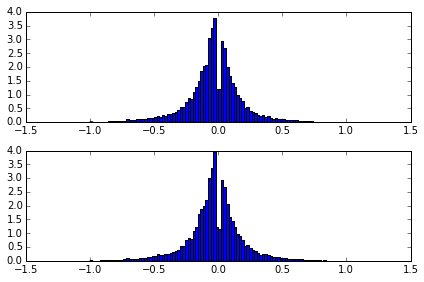

In [20]:
# plot distributions of delta and cor in rnd vs donor
# no significant difference
fig, axes = plt.subplots(nrows=2)
ax0, ax1 = axes.flat
hdata = mut_tf_prom[mut_tf_prom.delta != 0]
ax0.hist(hdata.delta[hdata.rnd].reset_index(drop=True), bins=100, normed=True)
ax1.hist(hdata.delta[hdata.rnd==False].reset_index(drop=True), bins=100, normed=True)
plt.tight_layout()
plt.show()

In [21]:
print len(set(mut_tf_prom['gene_name'][mut_tf_prom['delta'].abs()>5])), len(set(mut_tf_prom['gene_name']))

0 8020


In [22]:
# aggregate by donor, gene
x = mut_tf_prom[['gene_name', 'cancer', 'barcode', 'rnd', 'delta']]
x = x.groupby(['gene_name', 'cancer', 'barcode', 'rnd'])
x = x.aggregate([np.mean, np.sum, len, np.max, np.min, np.std])
x = x.unstack()
x['sumlen'] = x[('delta','len',False)] + x[('delta','len',True)]
x['difflen'] = x[('delta','len',False)] - x[('delta','len',True)]
x['fracdonor'] = x[('delta','len',False)] / x['sumlen']
x['diffmean'] = x[('delta','mean',False)] + x[('delta','mean',True)]
x['diffsum'] = x[('delta','sum',False)] - x[('delta','sum',True)]
x = x[(x['sumlen'] > 2) & (x['diffmean'] != 0)]
x = x.reset_index()
mut_tf_prom_barcode = x
x[:10]

gene_name cancer           barcode     delta                      \
                                             mean                 sum   
rnd                                         False      True     False   
0    NM_000014    CRC  TCGA-CA-6717-01A  0.015612  0.006338  0.078060   
1    NM_000014    CRC  TCGA-EI-6917-01A  0.000000 -0.037569  0.000000   
2    NM_000014   SKCM  TCGA-EE-A3J5-06A -0.005860  0.000000 -0.029298   
3    NM_000014   SKCM  TCGA-EE-A3JI-06A  0.000000 -0.078914  0.000000   
4    NM_000015   BRCA  TCGA-D8-A27H-01A  0.000000  0.084633  0.000000   
5    NM_000015    CRC  TCGA-A6-6141-01A -0.026342  0.000000 -0.158049   
6    NM_000015    CRC  TCGA-A6-6781-01A -0.044704 -0.016209 -0.402333   
7    NM_000015    CRC  TCGA-AA-3516-01A -0.003651 -0.018622 -0.069376   
8    NM_000015    CRC  TCGA-AA-3518-01A  0.000000 -0.033015  0.000000   
9    NM_000015    CRC  TCGA-AA-3555-01A -0.045984 -0.016888 -0.597792   

                                                                           \
                len          amax                amin                 std   
rnd      True False True    False      True     False      True     False   
0    0.050707     5    8  0.07806  0.050707  0.000000  0.000000  0.034910   
1   -0.150275     2    4  0.00000  0.000000  0.000000 -0.150275  0.000000   
2    0.000000     5    6  0.00000  0.000000 -0.029298  0.000000  0.013103   
3   -0.473486     3    6  0.00000  0.000000  0.000000 -0.473486  0.000000   
4    0.253898     2    3  0.00000  0.253898  0.000000  0.000000  0.000000   
5    0.000000     6    9  0.00000  0.000000 -0.158049  0.000000  0.064523   
6   -0.226919     9   14  0.00000  0.000000 -0.402333 -0.226919  0.134111   
7   -0.428310    19   23  0.00000  0.000000 -0.069376 -0.380969  0.015916   
8   -0.297131     8    9  0.00000  0.000000  0.000000 -0.297131  0.000000   
9   -0.270203    13   16  0.00000  0.000000 -0.496956 -0.270203  0.138337   

              sumlen difflen fracdonor  diffmean   diffsum  
                                                            
rnd      True                                               
0    0.017928     13      -3  0.384615  0.021950  0.027353  
1    0.075138      6      -2  0.333333 -0.037569  0.150275  
2    0.000000     11      -1  0.454545 -0.005860 -0.029298  
3    0.193300      9      -3  0.333333 -0.078914  0.473486  
4    0.146588      5      -1  0.400000  0.084633 -0.253898  
5    0.000000     15      -3  0.400000 -0.026342 -0.158049  
6    0.060647     23      -5  0.391304 -0.060912 -0.175414  
7    0.079602     42      -4  0.452381 -0.022274  0.358935  
8    0.099044     17      -1  0.470588 -0.033015  0.297131  
9    0.067551     29      -3  0.448276 -0.062872 -0.327590

In [23]:
# take those with largest changes in total TF binding, then those that occur in the most samples
x = mut_tf_prom_barcode
x = x[x['diffsum'].abs().rank(pct=True)>0.95]
x = x[['gene_name','barcode']].groupby('gene_name').aggregate({'barcode':len})
x = x.reset_index()
x = x[x['barcode'].rank(pct=True)>0.95]
x['gene_name'].to_csv('mut_tf_prom_barcode.txt',index=False)
# [Sheffield] enriched in GO terms for cell differentiation/development, and also synapse/neuron development (WTF??)
# [He] enriched in GO cell fate commitment, epithelium develo8pment, organ development (meh?)
# [Ernst, Thurman] similar - interesting terms on regulation, differentiation, development

In [327]:
# same thing but grouped by cancer type to look for significance within each tissue
x = mut_tf_prom_barcode.copy()
x['ranksum'] = x.groupby('cancer')['diffsum'].transform(lambda g: g.abs().rank(pct=True))
x = x[['gene_name','barcode','cancer']][x['ranksum']>0.98] # top 2% within each cancer type
x = x.groupby(['cancer', 'gene_name']).aggregate({'barcode':len}).reset_index()
x['ranklen'] = x.groupby('cancer')['barcode'].transform(lambda g: g.rank(pct=True))
x = x[x['ranklen'] > 0.95]
x.sort(['cancer', 'ranklen']).to_csv('mut_tf_prom_cancer.txt',index=False)
# [Sheffield] only significant in CRC, with same odd neuronal genes
# [He] significant in a couple of cancers, nothing pops out as a clear signal
# [Ernst, Thurman] nothing significant

In [328]:
x = mut_tf_prom_barcode
x = x.groupby('gene_name')
x = x.aggregate({'difflen': [np.min, np.mean, np.max, len],
                 'diffmean': [np.min, np.mean, np.std, np.max],
                 'diffsum': [np.min, np.mean, np.std, np.max]})
x = x.fillna(0)
x = x[x[('difflen','len')] > 1]
x.describe()

diffsum                                             difflen  \
              amin         mean          std         amax         amin   
count  4766.000000  4766.000000  4766.000000  4766.000000  4766.000000   
mean     -9.706341     0.165248     4.924501    10.276240    -7.891733   
std       7.513264     1.850089     1.976244     7.668002    10.202649   
min    -109.579098   -14.296541     0.000000   -12.087678  -236.000000   
25%     -13.159160    -0.692367     3.749148     5.073264   -10.000000   
50%      -8.818582     0.169181     4.929384     9.288128    -6.000000   
75%      -4.559768     1.034377     6.019467    13.769963    -3.000000   
max       9.182368    11.713606    20.616985    87.974455     3.000000   

                                                 diffmean               \
              mean         amax          len         amin         mean   
count  4766.000000  4766.000000  4766.000000  4766.000000  4766.000000   
mean     -0.812796     3.567772    25.602182    -3.720507    -0.306943   
std       1.011600     2.976706    30.036584     2.744307     0.828697   
min      -7.290102    -4.000000     2.000000   -27.885252    -9.311289   
25%      -1.400000     2.000000     6.000000    -4.971036    -0.561729   
50%      -0.826837     3.000000    15.000000    -3.221608    -0.235217   
75%      -0.243408     5.000000    34.000000    -1.850594     0.003928   
max       4.000000    31.000000   293.000000     2.446481     6.802243   

                                 
               std         amax  
count  4766.000000  4766.000000  
mean      1.589288     2.757347  
std       0.973000     2.502668  
min       0.001306    -5.645307  
25%       1.047038     1.032928  
50%       1.376599     2.253890  
75%       1.879663     3.907246  
max      11.998618    17.372379

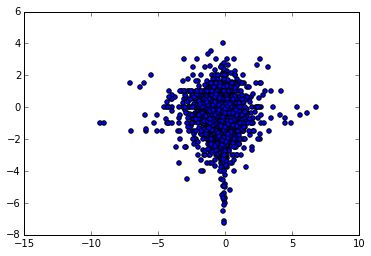

In [329]:
plt.scatter(x[('diffmean','mean')], x[('difflen','mean')])
plt.show()

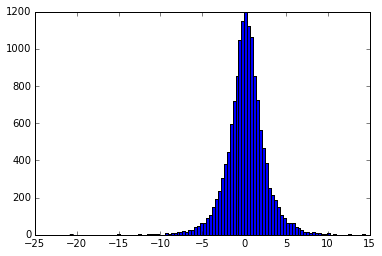

In [188]:
# GO shows no interesting terms for large diffsum
mut_tf_byprom = x
mut_tf_byprom[mut_tf_byprom[('diffsum','mean')].rank(pct=True) > 0.95].to_csv('mut_tf_byprom.txt')
# plot is just normal
plt.hist(mut_tf_byprom[('diffsum','mean')][mut_tf_byprom[('diffsum','mean')]!=0],100)
plt.show()

In [388]:
# get gene expression data
gx = pd.read_table('d:/sequence/pancan/tcga505/expression.tsv.gz', sep='\t')
gx.ENSEMBL_ID = gx.ENSEMBL_ID.map(lambda s: s.split('.')[0])
gx = gx.select(lambda c: c != 'symbol', axis=1)
gx = gx.set_index('ENSEMBL_ID')
gx = gx.T
gx = gx.reset_index()
gx = gx.rename(columns={'index':'barcode'})
gx = gx.merge(cmap, on='barcode', how='left')
def zscore_all(df):
    other = df.select_dtypes(exclude=[np.number])
    numeric = df.select_dtypes(include=[np.number])
    numeric = (numeric - numeric.mean()) / numeric.std()
    return pd.concat([other,numeric], axis=1)
gx = gx.groupby('cancer').apply(zscore_all)
gx = zscore_all(gx)
gx = gx.select(lambda c: c != 'cancer', axis=1)
gx = pd.melt(gx, 'barcode', value_name='expr')
gx[:10]

,barcode,ENSEMBL_ID,expr
0,TCGA-02-2483-01A,ENSG00000000003,-0.227847
1,TCGA-02-2485-01A,ENSG00000000003,-0.065449
2,TCGA-05-4389-01A,ENSG00000000003,1.147414
3,TCGA-05-4395-01A,ENSG00000000003,-1.048184
4,TCGA-05-4396-01A,ENSG00000000003,-0.934422
5,TCGA-05-4397-01A,ENSG00000000003,-0.117444
6,TCGA-05-4398-01A,ENSG00000000003,-0.524043
7,TCGA-05-4420-01A,ENSG00000000003,0.329611
8,TCGA-05-4422-01A,ENSG00000000003,-0.464641
9,TCGA-05-4432-01A,ENSG00000000003,-0.676132


In [423]:
#gx2 = gx.merge(geneids[['Ensembl Gene ID', 'HGNC symbol']].rename(columns={'Ensembl Gene ID': 'ENSEMBL_ID', 'HGNC symbol': 'gene_name'}))
#x = mut_tf_byprom.reset_index().rename(columns={'index':'gene_name'}).merge(gx2[['gene_name', 'expr']], on='gene_name', how='inner')
plt.scatter(x[('diffsum', 'mean')], x['expr'])
plt.show()

KeyError: ('diffsum', 'mean')

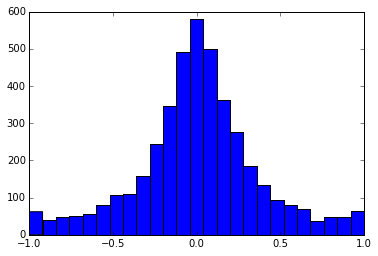

In [439]:
x = mut_tf_prom[mut_tf_prom.rnd == False][['barcode', 'gene_name', 'delta']]
y = geneids[['Ensembl Gene ID', 'RefSeq mRNA']].rename(columns={'Ensembl Gene ID':'ENSEMBL_ID', 'RefSeq mRNA':'gene_name'})
x = x.merge(y, on='gene_name', how='left')[['barcode', 'ENSEMBL_ID', 'delta']]
x = x.merge(gx, on=['barcode', 'ENSEMBL_ID'], how='inner').drop_duplicates()
x = x[x.delta !=0]
x2 = x
x = x.groupby('ENSEMBL_ID').apply(lambda g: g.delta.corr(g.expr) if len(g.delta) > 2 else np.nan)
plt.hist(x.dropna(), bins=25)
plt.show()

In [446]:
x2 = x2[x2.ENSEMBL_ID.isin(x[x.abs().rank(pct=True)>.99].index)].sort(['ENSEMBL_ID','delta','expr']).merge(pd.DataFrame({'ENSEMBL_ID': x.index, 'corr': x}), how='left')
x2[:15]

,barcode,ENSEMBL_ID,delta,expr,corr
0,TCGA-BT-A20P-01A,ENSG00000005884,2.445735,2.735984,-0.984782
1,TCGA-DK-A1AE-01A,ENSG00000005884,4.075503,-0.870798,-0.984782
2,TCGA-05-4397-01A,ENSG00000005884,4.453279,-0.884594,-0.984782
3,TCGA-91-6840-01A,ENSG00000057593,3.042860,1.415780,-0.999645
4,TCGA-AA-3956-01A,ENSG00000057593,4.792765,-0.203813,-0.999645
5,TCGA-78-7146-01A,ENSG00000057593,5.131289,-0.457070,-0.999645
6,TCGA-CZ-5987-01A,ENSG00000059915,-2.807355,-0.295482,-0.991103
7,TCGA-CA-6718-01A,ENSG00000059915,-2.236559,-0.308602,-0.991103
8,TCGA-AX-A0J1-01A,ENSG00000059915,-0.563652,-0.401482,-0.991103
9,TCGA-EI-6917-01A,ENSG00000073737,-0.739177,-0.471471,-0.999246


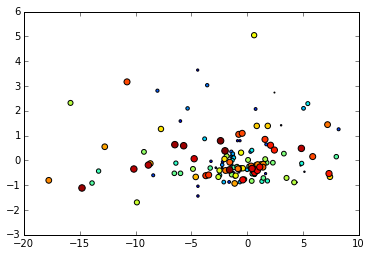

In [456]:
plt.scatter(x2.delta, x2.expr, s=1+pd.factorize(x2.ENSEMBL_ID)[0], c=pd.factorize(x2.ENSEMBL_ID)[0])
plt.show()

In [464]:
#x2.merge(geneids.rename(columns={'Ensembl Gene ID':'ENSEMBL_ID'}))
set(x2.ENSEMBL_ID)

{'ENSG00000005884',
 'ENSG00000057593',
 'ENSG00000059915',
 'ENSG00000073737',
 'ENSG00000074964',
 'ENSG00000090554',
 'ENSG00000100146',
 'ENSG00000101224',
 'ENSG00000105825',
 'ENSG00000107864',
 'ENSG00000108759',
 'ENSG00000109466',
 'ENSG00000111667',
 'ENSG00000112855',
 'ENSG00000116678',
 'ENSG00000121966',
 'ENSG00000123843',
 'ENSG00000124212',
 'ENSG00000124444',
 'ENSG00000125968',
 'ENSG00000129757',
 'ENSG00000134291',
 'ENSG00000134900',
 'ENSG00000137474',
 'ENSG00000137491',
 'ENSG00000139508',
 'ENSG00000143434',
 'ENSG00000143851',
 'ENSG00000144036',
 'ENSG00000147889',
 'ENSG00000152254',
 'ENSG00000157036',
 'ENSG00000163568',
 'ENSG00000163735',
 'ENSG00000166396',
 'ENSG00000168502',
 'ENSG00000171853',
 'ENSG00000172915',
 'ENSG00000173269',
 'ENSG00000179097',
 'ENSG00000179134',
 'ENSG00000183283',
 'ENSG00000185344'}

In [458]:
geneids[:5]

,Ensembl Gene ID,Ensembl Transcript ID,EntrezGene ID,RefSeq mRNA,HGNC symbol
0,ENSG00000210049,ENST00000387314,NaN,NaN,MT-TF
1,ENSG00000211459,ENST00000389680,NaN,NaN,MT-RNR1
2,ENSG00000210077,ENST00000387342,NaN,NaN,MT-TV
3,ENSG00000210082,ENST00000387347,NaN,NaN,MT-RNR2
4,ENSG00000209082,ENST00000386347,NaN,NaN,MT-TL1


In [24]:
mut_tf_prom.to_csv('mut_tf_prom_0925.csv')

In [25]:
mut_tf.to_csv('mut_tf_0925.csv')